# Preço pelo Bairro

In [ ]:
pip install category_encoders

In [ ]:
from glob import glob
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from category_encoders import OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

Na última lição, criamos um modelo que usava a localização — representada por latitude e longitude — para prever o preço. Nesta lição, vamos usar uma representação diferente para a localização: o bairro.

In [ ]:
def limpeza(filepath):
    df = pd.read_csv(filepath)

    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)

    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]

    df.drop(columns=["place_with_parent_names", "lat-lon"], inplace=True)

    return df

### Exercício:
Modifique sua função limpeza para criar uma nova característica chamada "neighborhood". Você pode encontrar o bairro de cada propriedade na coluna "place_with_parent_names". Por exemplo, uma propriedade com o nome do local "|Argentina|Capital Federal|Palermo|" está localizada no bairro "Palermo". Além disso, sua função deve remover a coluna "place_with_parent_names".

In [ ]:
df = limpeza('/content/drive/MyDrive/Buenos-Aires-2/buenos-aires-1.csv')
df.head(10)

Na última lição, usamos nossa função limpeza para importar dois arquivos CSV como DataFrames. Mas e se tivéssemos centenas de arquivos CSV para importar? Manipulá-los um por um não seria uma opção. Então, vamos começar com uma técnica para ler vários arquivos CSV em um único DataFrame.

O primeiro passo é reunir os nomes de todos os arquivos que queremos importar. Podemos fazer isso usando correspondência de padrões

### Exercício:
Use o `glob` para criar uma lista que contenha os nomes dos arquivos de todos os arquivos CSV de imóveis de Buenos Aires no diretório de dados. Atribua essa lista à variável chamada `files`.

In [ ]:
files = glob('/content/drive/MyDrive/Buenos-Aires-2/buenos-aires-?.csv')
files

O próximo passo é ler cada um dos arquivos CSV em `files` em um DataFrame e colocar todos esses DataFrames em uma lista. Qual é uma boa maneira de iterar por `files` para fazermos isso? Um laço `for`!

### Exercício:
Use sua função `limpeza` em um laço `for` para criar uma lista chamada `frames`. A lista deve conter os DataFrames limpos criados a partir dos nomes de arquivos CSV que você coletou em `files`.

In [ ]:
frames = []
for file in files:
  frames.append(limpeza(file))

display(frames[1].head())

### Exercício:
Use `pd.concat` para concatenar os itens em `frames` em um único DataFrame chamado `df`. Certifique-se de definir o argumento `ignore_index` como `True`.

In [ ]:
df = pd.concat(frames, ignore_index=True)
df.head(10)

# Dividir  
Neste ponto, você deve se sentir mais à vontade com a divisão dos dados, então vamos condensar todo o processo em uma única tarefa.

### Exercício:
Crie sua matriz de características `X_train` e o vetor de alvo `y_train`.

`X_train` deve conter uma característica: "neighborhood". Seu alvo é "price_aprox_usd".

In [ ]:
features = ["neighborhood"]
target = "price_aprox_usd"

y_train = df[target]
X_train = df[features]

# Baseline
Vamos também condensar o código que usamos para estabelecer nossa linha de base.

### Exercício:
Calcule o erro absoluto médio de linha de base para o seu modelo.

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Erro absoluto médio de linha de base:", mae_baseline.round(2))

# Iterar
Se você tentar ajustar um preditor `LinearRegression` aos seus dados de treinamento neste ponto, você receberá um erro que se parece com isto:

`ValueError: could not convert string to float`

O que isso significa? Quando você ajusta um modelo de regressão linear, está pedindo ao scikit-learn para realizar uma operação matemática.

O problema é que nosso conjunto de treinamento contém informações sobre o bairro em formato não numérico. Para criar nosso modelo, precisamos codificar essas informações para que sejam representadas numericamente.

A boa notícia é que existem muitos transformadores que podem fazer isso. Aqui, usaremos o transformador da biblioteca `Category Encoders`, chamado `OneHotEncoder.`

## OneHotEncoder
Transforma variáveis __categóricas__ em variáveis __binárias__ (dummies).

Por exemplo, se você tiver uma coluna com três categorias ("A", "B", "C"), o encoder criará três colunas binárias, uma para cada categoria.

- ## `use_cats_name:`
  - `use_cats_name = True:` Quando esta opção é ativada, o encoder usa os nomes das categorias para nomear as colunas resultantes. Isso é útil para garantir que as novas colunas criadas após a transformação sejam identificáveis e correspondam aos nomes originais das categorias.

  - `use_cats_name = False:` Se não ativado, o encoder pode usar uma nomenclatura padrão para as colunas resultantes, o que pode ser menos intuitivo para a interpretação posterior.

### Exercício:
Primeiro, instancie um `OneHotEncoder` chamado `ohe`.
Certifique-se de definir o argumento `use_cat_names` como `True`.

Em seguida, ajuste seu transformador à matriz de características `X_train`.

Por fim, use seu codificador para transformar a matriz de características `X_train` e atribua os dados transformados à variável `XT_train`.

In [ ]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)

XT_train.head()

## Ridge
O Ridge é uma forma de regressão linear que inclui um termo de regularização. Ele é uma técnica de __regressão linear regularizada__, onde o modelo tenta minimizar o erro de previsão, mas também penaliza grandes coeficientes para evitar overfitting.

### Por que usar Ridge e OneHotEncoder juntos?
A regularização do Ridge ajuda a prevenir overfitting, especialmente em situações onde há muitas características (como muitas variáveis dummies geradas pelo OneHotEncoder).

Sem regularização, o modelo pode se ajustar demais aos dados de treinamento e performar mal em dados novos.

### Overfitting
Overfitting é um problema que ocorre quando um modelo de machine learning aprende muito bem os dados de treinamento, incluindo o ruído e as peculiaridades específicas desses dados, mas não generaliza bem para novos dados.

Isso significa que o modelo tem um desempenho muito bom em seus dados de treinamento, mas seu desempenho em dados não vistos (dados de teste) é ruim. Em outras palavras, o modelo está “superajustado” aos dados de treinamento.

### Exercício:
Crie um pipeline chamado `model` que contenha um transformador `OneHotEncoder` e um preditor de Regressão Linear.

Em seguida, ajuste seu modelo aos dados de treinamento.

In [ ]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

# Avaliar  
Independentemente de como você construa seu modelo, o passo de avaliação permanece o mesmo. Vamos ver como nosso modelo se desempenha com o conjunto de treinamento.

### Exercício:
Primeiro, crie uma lista de previsões para as observações na sua matriz de características `X_train`. Nomeie essa lista como `y_pred_training`.

Em seguida, calcule o erro absoluto médio de treinamento para suas previsões em `y_pred_training` em comparação com os alvos reais em `y_train`.

In [ ]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)

round(mae_training,2)

### Exercício:
Importe seus dados de teste `buenos-aires-features.csv` para um DataFrame e gere um Series de previsões usando seu modelo.

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/Buenos-Aires-2/buenos-aires-features.csv')[features]
y_pred_test = pd.Series(model.predict(X_test))

y_pred_test.head()

# Comunicar Resultados  
Se escrevermos a equação para o nosso modelo, ela será grande demais para caber na tela. Isso ocorre porque, ao usar o `OneHotEncoder` para codificar os dados do bairro, criamos um DataFrame muito mais largo, e cada coluna/característica tem seu próprio coeficiente na equação do modelo.

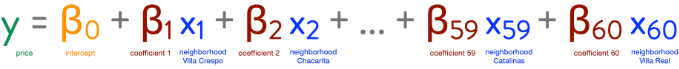

Isso é importante manter em mente por duas razões. Primeiro, significa que este é um modelo de alta dimensionalidade. Em vez de um gráfico 2D ou 3D, precisaríamos de um gráfico 58-dimensional para representá-lo, o que é impossível! Segundo, significa que precisaremos extrair e representar as informações para nossa equação de uma forma um pouco diferente do que antes. Vamos começar obtendo o intercepto e os coeficientes.

### Exercício:
Extraia o intercepto e os coeficientes do seu modelo.

In [ ]:
intercept = model.named_steps['ridge'].intercept_
coef = model.named_steps['ridge'].coef_

coef[:5]

Temos os valores dos nossos coeficientes, mas como sabemos a quais características eles pertencem? Precisaremos obter essa informação acessando a parte do nosso pipeline que fez a codificação.

### Exercício:
Extraia os nomes das características dos seus dados codificados do `OneHotEncoder` no seu modelo.

In [ ]:
features_names = model.named_steps['onehotencoder'].get_feature_names()
features_names[:5]

Temos coeficientes e nomes das características, e agora precisamos juntá-los. Para isso, usaremos um `Series`.

### Exercício:
Crie uma `Series` do pandas chamada `feat_imp`, onde o índice é suas características e os valores são seus coeficientes.

In [ ]:
feat_imp = pd.Series(coef, index=features_names)
feat_imp.head(10)

Para ser claro, definitivamente não é uma boa ideia mostrar essa equação, mas vamos imprimi-la apenas para verificar nosso trabalho.

Como há muitos termos para imprimir, usaremos um laço for.

In [ ]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})", end='')

### Exercício:
Crie um gráfico de barras horizontal que mostre os 15 principais coeficientes do seu modelo, com base no valor absoluto deles.

In [ ]:
feat_imp.sort_values(key=abs).tail(15).plot(kind='barh')
plt.xlabel('Importance [USD]')
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price')
plt.show()